In [13]:
import numpy as np
import math as math
import pandas as pd
import itertools as it
from gurobipy import *
import matplotlib.pyplot as plt

In [14]:
# import os
# os.getcwd()
# files = [f for f in os.listdir('.') if os.path.isfile(f)]
# for f in files:
#     print(f)

In [15]:
gurobipy.gurobi.version()

(11, 0, 0)

## Parameters and Costs

In [16]:
# Create parameters
site_df = pd.read_excel("Solar Grazing v1.3.1.xlsx", sheet_name="Attributes", header=2, usecols="A:C", nrows=5, dtype={'Site Attributes':'str', 'Variable':'str', 'Value':'float'}, index_col='Variable')
display(site_df)
flock_df = pd.read_excel("Solar Grazing v1.3.1.xlsx", sheet_name="Attributes", header=9, usecols="A:C", nrows=9, names=['Flock Attributes', 'Variable', 'Value'], dtype={'Flock Attributes':'str', 'Variable':'str', 'Value':'float'}, index_col='Variable')
display(flock_df)
financial_df = pd.read_excel("Solar Grazing v1.3.1.xlsx", sheet_name="Attributes", header=20, usecols="A:C", nrows=2, names=['Financial Parameters', 'Variable', 'Value'], dtype={'Financial Parameters':'str', 'Variable':'str', 'Value':'float'}, index_col='Variable')
financial_df.loc['discRate'] = ['Discount Rate',financial_df.loc['intRate']['Value']*0.75]
display(financial_df)

# Store parameters in dictionaries
site = site_df['Value'].to_dict()
flock = flock_df['Value'].to_dict()
financial = financial_df['Value'].to_dict()
financial['discRate'] = financial['intRate']*0.75

print('Site Characteristics:\n', site, '\n')
print('Flock Characteristics:\n',flock, '\n')
print('Financial Parameters:\n',financial)

# Create costs dataframe
costs_df = pd.read_excel("Solar Grazing v1.3.1.xlsx", sheet_name="Attributes", header=25, usecols="A:E", nrows=12, names=['Item', 'Upfront',"Fixed per Year per Acre","Per Head per Year","Fixed per Year"], dtype={'Item':'str'}, index_col='Item')
costs_df.fillna(0, inplace=True)
display(costs_df)

,Site Attributes,Value
Variable,,
acres,Acres,100.0
revperacre,Annual Revenue per Acre,380.0
sheepperacre,Sheep per Acre,5.0
mowNoSheep,Mowing cost per acre (0 sheep),400.0
mowMax,Mowing cost per acre (max sheep),40.0


,Flock Attributes,Value
Variable,,
beginFlock,Beginning Flock Size,100.00
maxflock,Maximum Flock Size,500.00
repro,Reproduction Rate,1.80
cull,Annual Cull Rate,0.20
death,Annual Death Rate,0.03
eweCost,Cost per Ewe,300.00
revRamLamb,Revenue per Ram Lamb,250.00
revEweLamb,Revenue per Ewe Lamb,250.00
revCull,Revenue per Ewe Culled,100.00


,Financial Parameters,Value
Variable,,
intRate,Interest Rate,0.08
loanYears,Loan Duration (Years),6.00
discRate,Discount Rate,0.06


Site Characteristics:
 {'acres': 100.0, 'revperacre': 380.0, 'sheepperacre': 5.0, 'mowNoSheep': 400.0, 'mowMax': 40.0} 

Flock Characteristics:
 {'beginFlock': 100.0, 'maxflock': 500.0, 'repro': 1.8, 'cull': 0.2, 'death': 0.03, 'eweCost': 300.0, 'revRamLamb': 250.0, 'revEweLamb': 250.0, 'revCull': 100.0} 

Financial Parameters:
 {'intRate': 0.08, 'loanYears': 6.0, 'discRate': 0.06}


,Upfront,Fixed per Year per Acre,Per Head per Year,Fixed per Year
Item,,,,
Mowing,0.0,400.0,-72.0,0.0
Insurance,0.0,0.0,0.0,14000.0
Transportation,0.0,0.0,15.0,0.0
Water Hauling,0.0,0.0,0.0,5400.0
Vet care,0.0,0.0,10.0,0.0
Minerals,0.0,0.0,25.0,0.0
Overwintering,0.0,0.0,110.0,0.0
Staffing,0.0,0.0,50.0,50000.0
Guard dogs,0.0,0.0,0.0,600.0


### To update attributes or costs, use the helper functions below.

In [17]:
# Update attribute
def setAttr(variable: str, value):
    assert variable != 'maxflock', "You are not allowed to manually change this attribute."
    i = [variable in site.keys(), variable in flock.keys(), variable in financial.keys()].index(True)
    [site, flock, financial][i][variable] = value
    [site_df, flock_df, financial_df][i].loc[variable]['Value'] = value
    if variable == 'acres':
        flock['maxflock'] == site['sheepperacre'] * site['acres']
    if variable in ['mowNoSheep', 'mowMax']:
        costs_df.loc['Mowing']['Per Head per Year'] = -1*(site['mowNoSheep'] - site['mowMax'])*site['acres']/flock['maxflock']

# Get attribute
def getAttr(variable: str) :
    assert [variable in site.keys(), variable in flock.keys(), variable in financial.keys()].index(True) in [0,1,2]
    i = [variable in site.keys(), variable in flock.keys(), variable in financial.keys()].index(True)
    return [site, flock, financial][i][variable]

# Update cost
def setCost(item, cost_type, value):
    assert (item,cost_type) != ('Mowing','Per Head per Year'), "You are not allowed to manually change this cost."
    costs_df.loc[item][cost_type] = value
    costs_df.loc['Total'][cost_type] = sum(costs_df[cost_type][:-1])
    
# print(getAttr('acres')) # Get attribute
# print(costs_df.loc['Mowing']['Per Head per Year'])

# setAttr('acres', 110) # Set attribute
# print(getAttr('acres'))
# print(costs_df.loc['Mowing']['Per Head per Year'])

# setAttr('acres', 100)
# print(getAttr('acres'))
# print(costs_df.loc['Mowing']['Per Head per Year'])

# IP Base Model - Buy Some Sheep Upfront with Loan

In [18]:
# Time Horizon
T = 10
years = list(range(1,T+1))

# Loan Term
L = int(financial['loanYears']) 
loanYears = list(range(1,L+1))

# Post-Loan Term
noLoanYears = list(np.arange(L+1, T+1, 1))

# Big M
M = 10**15

# # Loan Payment Calculation
# def loan_payment(numSheep, eweCost, loanYears, intRate):
#     return (numSheep*eweCost*intRate)/(1-(1+intRate)**(-loanYears))

In [19]:
print(years)
print('Loan Years:', loanYears, ', Post-loan Years:', noLoanYears)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Loan Years: [1, 2, 3, 4, 5, 6] , Post-loan Years: [7, 8, 9, 10]


In [20]:
# Model
m1 = Model("base_model")
# Variables
# number of sheep bought upfront
x = m1.addVar(lb=0, ub=getAttr('maxflock') - getAttr('beginFlock'), vtype=GRB.INTEGER, name="x") 
# revenue
R = m1.addVars(years, lb=0, vtype=GRB.CONTINUOUS, name="R")
# cost
C = m1.addVars(years, lb=0, vtype=GRB.CONTINUOUS, name="C") 
# annual loan payment
P = m1.addVar(lb=0, vtype=GRB.CONTINUOUS, name="P") 
# end-of-year flock size
n = m1.addVars([0] + years, lb=0, ub=getAttr('maxflock'), vtype=GRB.INTEGER, name="n") 
# Ewes to sell
m = m1.addVars(years, lb=0, vtype=GRB.INTEGER, name="m") 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-27


In [21]:
# Constraints
# revenue equation
m1.addConstrs(getAttr('acres')*getAttr('revperacre') + n[t-1]*(0.5*getAttr('repro')*getAttr('revRamLamb') + getAttr('revCull')*getAttr('cull')) + getAttr('revEweLamb')*m[t] == R[t] for t in years)
# cost equation during loan term
m1.addConstr(P == (x*getAttr('eweCost')*getAttr('intRate'))/(1-(1+getAttr('intRate'))**(-getAttr('loanYears'))))
m1.addConstrs(P + getAttr('acres')*costs_df.loc['Total']['Fixed per Year per Acre'] + 0.5*(n[t-1] + n[t])*costs_df.loc['Total']['Per Head per Year'] + costs_df.loc['Total']['Fixed per Year'] == C[t] for t in loanYears) 
# cost equation after loan term
m1.addConstrs(getAttr('acres')*costs_df.loc['Total']['Fixed per Year per Acre'] + 0.5*(n[t-1] + n[t])*costs_df.loc['Total']['Per Head per Year'] + costs_df.loc['Total']['Fixed per Year'] == C[t] for t in noLoanYears)
# sheep on hand plus number of sheep bought upfront is end-of-year-0 flock size
m1.addConstr(n[0] == getAttr('beginFlock') + x ) 
# end-of-year flock size equation
m1.addConstrs(n[t-1]*(1+0.5*getAttr('repro')-getAttr('death')-getAttr('cull')) - m[t] == n[t] for t in years) 

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

In [22]:
# The objective is to maximize the Net Present Value of yearly cash flows.
m1.setObjective(-(costs_df.loc['Total']['Upfront'] + getAttr('beginFlock')*getAttr('eweCost')) + quicksum((R[t] - C[t])/(1 + getAttr('discRate'))**t for t in years), GRB.MAXIMIZE)

In [23]:
# solve
m1.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G651)

CPU model: Intel(R) Core(TM) i5-6360U CPU @ 2.00GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 32 rows, 43 columns and 100 nonzeros
Model fingerprint: 0x6a5ec510
Variable types: 21 continuous, 22 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [6e-01, 9e-01]
  Bounds range     [4e+02, 5e+02]
  RHS range        [1e+02, 1e+05]
Presolve removed 32 rows and 43 columns
Presolve time: 0.05s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 383166 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.831664977276e+05, best bound 3.831664977276e+05, gap 0.0000%


In [24]:
# Print the objective value
print("The optimal objective is", m1.objVal)
print("The optimal flock size purchase is", m1.getVars()[0].x, "sheep")

The optimal objective is 383166.4977275911
The optimal flock size purchase is 400.0 sheep


In [25]:
m1.getVars()

[<gurobi.Var x (value 400.0)>,
 <gurobi.Var R[1] (value 244250.0)>,
 <gurobi.Var R[2] (value 244250.0)>,
 <gurobi.Var R[3] (value 244250.0)>,
 <gurobi.Var R[4] (value 244250.0)>,
 <gurobi.Var R[5] (value 244250.0)>,
 <gurobi.Var R[6] (value 244250.0)>,
 <gurobi.Var R[7] (value 244250.0)>,
 <gurobi.Var R[8] (value 244250.0)>,
 <gurobi.Var R[9] (value 244250.0)>,
 <gurobi.Var R[10] (value 369250.0)>,
 <gurobi.Var C[1] (value 204957.84634748116)>,
 <gurobi.Var C[2] (value 204957.84634748116)>,
 <gurobi.Var C[3] (value 204957.84634748116)>,
 <gurobi.Var C[4] (value 204957.84634748116)>,
 <gurobi.Var C[5] (value 204957.84634748116)>,
 <gurobi.Var C[6] (value 204957.84634748116)>,
 <gurobi.Var C[7] (value 179000.0)>,
 <gurobi.Var C[8] (value 179000.0)>,
 <gurobi.Var C[9] (value 179000.0)>,
 <gurobi.Var C[10] (value 144500.0)>,
 <gurobi.Var P (value 25957.84634748116)>,
 <gurobi.Var n[0] (value 500.0)>,
 <gurobi.Var n[1] (value 500.0)>,
 <gurobi.Var n[2] (value 500.0)>,
 <gurobi.Var n[3] (val

# IP Model 2 - Culling by Age

In [26]:
# print(getAttr('acres')) # Get attribute
# print(costs_df.loc['Mowing']['Per Head per Year'])

# setAttr('acres', 110) # Set attribute
# print(getAttr('acres'))
# print(costs_df.loc['Mowing']['Per Head per Year'])

# setAttr('acres', 100)
# print(getAttr('acres'))
# print(costs_df.loc['Mowing']['Per Head per Year'])
setAttr('repro', 1.8)

<ipython-input-17-b39cb7f3b716>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  [site_df, flock_df, financial_df][i].loc[variable]['Value'] = value


In [27]:
# Time Horizon
T = 20
years = list(range(1,T+1))

# Loan Term
L = int(getAttr('loanYears')) 
loanYears = list(range(1,L+1))

# Post-Loan Term
noLoanYears = list(np.arange(L+1, T+1, 1))

# Age Groups
lastAge = 5
ages = list(range(1,lastAge + 1))

print('Time Horizon:',years)
print('Loan Years:', loanYears, ', Post-loan Years:', noLoanYears)
print("Age Groups:", ages)

# Cartesian product
yearsAges = list(it.product([0]+years,ages))

Time Horizon: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Loan Years: [1, 2, 3, 4, 5, 6] , Post-loan Years: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Age Groups: [1, 2, 3, 4, 5]


In [28]:
# Model
m2 = Model("model_2")

# New Parameters
# p(t,i): cull price of sheep aged i in year t
p = {i:getAttr('revRamLamb') for i in yearsAges}
for t in years:
    p[(t,1)] = getAttr('revRamLamb')
    p[(t,2)] = (getAttr('revCull') + getAttr('revRamLamb'))/2
    p[(t,3)] = (getAttr('revCull') + getAttr('revRamLamb'))/2
    p[(t,4)] = (getAttr('revCull') + getAttr('revRamLamb'))/2
    p[(t,5)] = getAttr('revCull')
#     p[(t,5)] = getAttr('revCull')
# c(t): cost per head in year t
c = {t:costs_df.loc['Total']['Per Head per Year'] for t in years}

# w = {t:costs_df.loc['Overwintering']['Per Head per Year'] for t in years}
# w[t] = ...
# m = {t:(getAttr('mowMax')-getAttr('mowNoSheep')*getAttr('acres')/getAttr('maxflock')) for t in years}
# m[t] = ...
# c[t] = (costs_df.loc['Vet care']['Per Head per Year'] + costs_df.loc['Transportation']['Per Head per Year'] + costs_df.loc['Staffing']['Per Head per Year']) + w[t] + m[t]

# Variables
# number of sheep from each age group at end of year
x = m2.addVars(yearsAges, lb=0, vtype=GRB.CONTINUOUS, name='x')
# number of sheep sold from each age group at end of year
y = m2.addVars(yearsAges, lb=0, vtype=GRB.CONTINUOUS, name='y')
# number of sheep bought upfront from each age group
n = m2.addVars(ages, lb=0, ub=getAttr('maxflock'), vtype=GRB.CONTINUOUS, name="n") 
# revenue
R = m2.addVars(years, lb=0, vtype=GRB.CONTINUOUS, name="R") 
# cost
C = m2.addVars(years, lb=0, vtype=GRB.CONTINUOUS, name="C")
# annual loan payment
P = m2.addVar(lb=0, vtype=GRB.CONTINUOUS, name="P") 

In [29]:
# Constraints
# revenue equation
m2.addConstrs((getAttr('acres')*getAttr('revperacre') + quicksum(p[(t,i)]*y[(t,i)] for i in ages) == R[t] for t in years),"")
# cost equation during loan term
m2.addConstr((P == (getAttr('intRate')*getAttr('eweCost')*quicksum(n[i] for i in ages))/(1-(1+getAttr('intRate'))**(-getAttr('loanYears')))),"")
m2.addConstrs((P + costs_df.loc['Total']['Fixed per Year'] + getAttr('acres')*costs_df.loc['Total']['Fixed per Year per Acre'] + c[t]*quicksum(x[(t,i)] - y[(t,i)] for i in ages) == C[t] for t in loanYears),"") 
# cost equation after loan term
m2.addConstrs((costs_df.loc['Total']['Fixed per Year'] + getAttr('acres')*costs_df.loc['Total']['Fixed per Year per Acre'] + c[t]*quicksum(x[(t,i)] - y[(t,i)] for i in ages) == C[t] for t in noLoanYears),"")
# sheep on hand plus number of sheep bought upfront is initial inventory
m2.addConstrs((n[i] + getAttr('beginFlock')/5 == x[(0,i)] for i in ages),"")
# end-of-year post-cull inventory should not exceed max flock size
m2.addConstrs((getAttr('maxflock') >= quicksum(x[(t,i)] - y[(t,i)] for i in ages) for t in ([0]+years)),"")
# Age 1 sheep
m2.addConstrs(((1-getAttr('death'))*getAttr('repro')*quicksum(x[(t,i)] for i in ages[1:]) == x[(t+1,1)] for t in ([0]+years[:-1])),"")
# Ages 2-5 sheep
m2.addConstrs(((1-getAttr('death'))*(x[(t,i)] - y[(t,i)]) == x[(t+1,i+1)] for i in ages[:-1] for t in ([0]+years[:-1]) ),"")
# Number of 1-year-olds culled must be at least the number of ram lambs
m2.addConstrs(((1-getAttr('death'))*(getAttr('repro')/2)*quicksum(x[(t,i)] for i in ages[1:]) <= y[(t+1,1)] for t in ([0]+years[:-1]) ),"")
# All 5-year-olds culled
m2.addConstrs((x[(t,5)] == y[(t,5)] for t in years ),"")
# Don't cull in year 0
m2.addConstrs((y[(0,i)] == 0 for i in ages ),"")
# Number of culls cannot exceed inventory size
m2.addConstrs((y[(t,i)] <= x[(t,i)] for t in ([0]+years) for i in ages),"")

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4): <gurobi.Constr *Awaiting Model Update*>,
 (3, 5): <gurobi.Constr *Awaiting Model Update*>,


In [30]:
# The objective is to maximize the Net Present Value of yearly cash flows.
m2.setObjective(-(costs_df.loc['Total']['Upfront'] + getAttr('beginFlock')*getAttr('eweCost')) + quicksum((R[t] - C[t])/(1 + getAttr('discRate'))**t for t in years), GRB.MAXIMIZE)

In [31]:
# solve
m2.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 21.6.0 21G651)

CPU model: Intel(R) Core(TM) i5-6360U CPU @ 2.00GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 317 rows, 256 columns and 1267 nonzeros
Model fingerprint: 0x06d7b6be
Coefficient statistics:
  Matrix range     [9e-01, 2e+02]
  Objective range  [3e-01, 9e-01]
  Bounds range     [5e+02, 5e+02]
  RHS range        [2e+01, 1e+05]
Presolve removed 208 rows and 132 columns
Presolve time: 0.01s
Presolved: 109 rows, 124 columns, 676 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2869186e+33   1.002759e+32   7.286919e+03      0s
     114    5.1443448e+05   0.000000e+00   0.000000e+00      0s

Solved in 114 iterations and 0.04 seconds (0.00 work units)
Optimal objective  5.144344775e+05


In [33]:
# Print the objective value
print("The optimal objective is", m2.objVal)
solStr = []
for key in list(n.keys())[:5]:
    solStr.append("\n" + str(n[key].x) + " " + str(key) + "-year-old" +  " sheep")
print("The optimal flock size purchase is:", "".join(solStr)+".")

The optimal objective is 514434.47745749366
The optimal flock size purchase is: 
0.0 1-year-old sheep
400.0 2-year-old sheep
0.0 3-year-old sheep
0.0 4-year-old sheep
0.0 5-year-old sheep.


In [34]:
m2.getVars()

[<gurobi.Var x[0,1] (value 20.0)>,
 <gurobi.Var x[0,2] (value 420.0)>,
 <gurobi.Var x[0,3] (value 20.0)>,
 <gurobi.Var x[0,4] (value 20.0)>,
 <gurobi.Var x[0,5] (value 20.0)>,
 <gurobi.Var x[1,1] (value 838.08)>,
 <gurobi.Var x[1,2] (value 19.4)>,
 <gurobi.Var x[1,3] (value 407.4)>,
 <gurobi.Var x[1,4] (value 19.4)>,
 <gurobi.Var x[1,5] (value 19.4)>,
 <gurobi.Var x[2,1] (value 812.9376)>,
 <gurobi.Var x[2,2] (value 74.71320000000003)>,
 <gurobi.Var x[2,3] (value 18.817999999999998)>,
 <gurobi.Var x[2,4] (value 391.4687999999999)>,
 <gurobi.Var x[2,5] (value 0.0)>,
 <gurobi.Var x[3,1] (value 846.8099999999998)>,
 <gurobi.Var x[3,2] (value 394.27473599999996)>,
 <gurobi.Var x[3,3] (value 72.47180400000002)>,
 <gurobi.Var x[3,4] (value 18.253459999999997)>,
 <gurobi.Var x[3,5] (value 0.0)>,
 <gurobi.Var x[4,1] (value 846.8100000000001)>,
 <gurobi.Var x[4,2] (value 32.25585620000004)>,
 <gurobi.Var x[4,3] (value 382.44649391999997)>,
 <gurobi.Var x[4,4] (value 70.29764988000002)>,
 <gurob

In [35]:
x

{(0, 1): <gurobi.Var x[0,1] (value 20.0)>,
 (0, 2): <gurobi.Var x[0,2] (value 420.0)>,
 (0, 3): <gurobi.Var x[0,3] (value 20.0)>,
 (0, 4): <gurobi.Var x[0,4] (value 20.0)>,
 (0, 5): <gurobi.Var x[0,5] (value 20.0)>,
 (1, 1): <gurobi.Var x[1,1] (value 838.08)>,
 (1, 2): <gurobi.Var x[1,2] (value 19.4)>,
 (1, 3): <gurobi.Var x[1,3] (value 407.4)>,
 (1, 4): <gurobi.Var x[1,4] (value 19.4)>,
 (1, 5): <gurobi.Var x[1,5] (value 19.4)>,
 (2, 1): <gurobi.Var x[2,1] (value 812.9376)>,
 (2, 2): <gurobi.Var x[2,2] (value 74.71320000000003)>,
 (2, 3): <gurobi.Var x[2,3] (value 18.817999999999998)>,
 (2, 4): <gurobi.Var x[2,4] (value 391.4687999999999)>,
 (2, 5): <gurobi.Var x[2,5] (value 0.0)>,
 (3, 1): <gurobi.Var x[3,1] (value 846.8099999999998)>,
 (3, 2): <gurobi.Var x[3,2] (value 394.27473599999996)>,
 (3, 3): <gurobi.Var x[3,3] (value 72.47180400000002)>,
 (3, 4): <gurobi.Var x[3,4] (value 18.253459999999997)>,
 (3, 5): <gurobi.Var x[3,5] (value 0.0)>,
 (4, 1): <gurobi.Var x[4,1] (value 846.8

In [36]:
m1.getVars()

[<gurobi.Var x (value 400.0)>,
 <gurobi.Var R[1] (value 244250.0)>,
 <gurobi.Var R[2] (value 244250.0)>,
 <gurobi.Var R[3] (value 244250.0)>,
 <gurobi.Var R[4] (value 244250.0)>,
 <gurobi.Var R[5] (value 244250.0)>,
 <gurobi.Var R[6] (value 244250.0)>,
 <gurobi.Var R[7] (value 244250.0)>,
 <gurobi.Var R[8] (value 244250.0)>,
 <gurobi.Var R[9] (value 244250.0)>,
 <gurobi.Var R[10] (value 369250.0)>,
 <gurobi.Var C[1] (value 204957.84634748116)>,
 <gurobi.Var C[2] (value 204957.84634748116)>,
 <gurobi.Var C[3] (value 204957.84634748116)>,
 <gurobi.Var C[4] (value 204957.84634748116)>,
 <gurobi.Var C[5] (value 204957.84634748116)>,
 <gurobi.Var C[6] (value 204957.84634748116)>,
 <gurobi.Var C[7] (value 179000.0)>,
 <gurobi.Var C[8] (value 179000.0)>,
 <gurobi.Var C[9] (value 179000.0)>,
 <gurobi.Var C[10] (value 144500.0)>,
 <gurobi.Var P (value 25957.84634748116)>,
 <gurobi.Var n[0] (value 500.0)>,
 <gurobi.Var n[1] (value 500.0)>,
 <gurobi.Var n[2] (value 500.0)>,
 <gurobi.Var n[3] (val

Text(0.5, 1.0, 'Sheep at End of Year and Culled Sheep per Year')

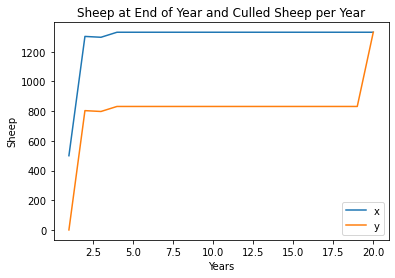

In [37]:
totalx = []
for t in years:
    totalx.append(sum(list(x.items())[i][1].x for i in range((t-1)*5,t*5)))
totaly = []
for t in years:
    totaly.append(sum(list(y.items())[i][1].x for i in range((t-1)*5,t*5)))
plt.plot(years, totalx, label='x')
plt.xlabel('Years')
plt.ylabel('Sheep')
plt.plot(years, totaly, label='y')
plt.legend()
plt.title('Sheep at End of Year and Culled Sheep per Year')

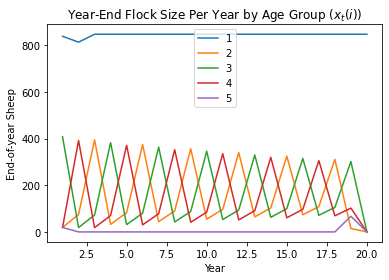

In [39]:
xdict={i:[] for i in ages}
for i in ages:
    for key in list(x.keys())[5:]:
        if key[1] == i:
            xdict[i].append(x[key].x)
for i in ages:
    plt.plot(years, xdict[i], label='%d'%i)
plt.xlabel('Year')
plt.ylabel('End-of-year Sheep')
plt.title('Year-End Flock Size Per Year by Age Group ($x_t(i)$)')
plt.legend()

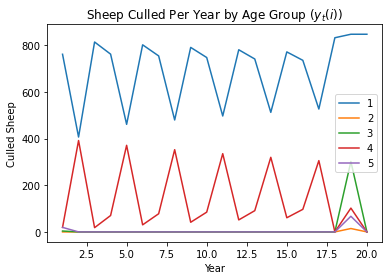

In [41]:
ydict={i:[] for i in ages}
for i in ages:
    for key in list(y.keys())[5:]:
        if key[1] == i:
            ydict[i].append(y[key].x)
for i in ages:
    plt.plot(years, ydict[i], label='%d'%i)
plt.xlabel('Year')
plt.ylabel('Culled Sheep')
plt.title('Sheep Culled Per Year by Age Group ($y_t(i)$)')
plt.legend()